# LJポテンシャル での 分子挙動(ルンゲクッタ)

このノートブックはK.B.砂糖さんの
[立方2最密&無惨様シミュレータ.ipynb](https://github.com/KB-satou/GotchaGotcha/blob/master/%E7%AB%8B%E6%96%B92%E6%9C%80%E5%AF%86%26%E7%84%A1%E6%83%A8%E6%A7%98%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%82%BF.ipynb)を適当にいじって、勝手に遊ばせてもらったものです。

配列とか適当なので、条件かえると飛ぶかもです。

In [1]:
using Plots,LinearAlgebra

## LJポテンシャル

In [2]:
function LJ(r:: Float64)
    return (1/r^12 - 2/r^6) 
end

# 微分形
function LJforce(r::Float64)
    return 12*(1/r^14-1/r^8)
end

LJforce (generic function with 1 method)

In [3]:
function force(Ux)
    N=length(Ux)÷3
    Fx=zeros(size(Ux))
    for i in 1:N-1
        for j in i+1:N
            ll = norm(Ux[j,:]-Ux[i,:])
            FLJ = LJforce(ll) * (Ux[j,:]-Ux[i,:])
            Fx[i,:] .-= FLJ
            Fx[j,:] .+= FLJ
        end
    end
    return Fx
end

force (generic function with 1 method)

## ルンゲクッタ 
履歴返す

In [4]:
function ルンゲクッタ(Ux,Vx; T=2., dt=1e-1)
    numStep = length(0:dt:T)
    Uxlist = zeros(size(Ux)...,numStep)

    for i in 1:numStep
        # リストに書き込む
        Uxlist[:,:,i] = Ux
        
        # 微小変化の計算
        # k1
        dUx1 = Vx
        dVx1 = force(Ux)

        # k2
        Ux1 = Ux + 0.5dt * dUx1 #5dt=>0.5dt
        Vx1 = Vx + 0.5dt * dVx1 #5dt=>0.5dt
        dUx2 = Vx1
        dVx2 = force(Ux1)
        
        # k3
        Ux2 = Ux + 0.5dt * dUx2 #5dt=>0.5dt
        Vx2 = Vx + 0.5dt * dVx2 #5dt=>0.5dt
        dUx3 = Vx2
        dVx3 = force(Ux2)
        
        # k4
        Ux3 = Ux + dt * dUx3
        Vx3 = Vx + dt * dVx3
        dUx4 = Vx3
        dVx4 = force(Ux3)
        
        # がっちゃんこ
        Ux += dt / 6 * ( dUx1 + 2dUx2 + 2dUx3 + dUx4)
        Vx += dt / 6 * ( dVx1 + 2dVx2 + 2dVx3 + dVx4)
  end
  return Uxlist
end

ルンゲクッタ (generic function with 1 method)

In [11]:
K,L,M = 4,4,4
N = K*L*M

iniUx=Array{Float64,2}(undef,N,3)
iniVx=zeros(N,3)

I = 0
for i in 1:K , j in 1:L ,k in 1:M
      I+=1
      iniUx[I,:] = [i,j,k]
end
T=20
dt=5e-3
@time Uxlist = ルンゲクッタ(iniUx, iniVx ;T=T,dt=dt)


 40.586561 seconds (290.48 M allocations: 30.452 GiB, 16.06% gc time)


64×3×4001 Array{Float64,3}:
[:, :, 1] =
 1.0  1.0  1.0
 1.0  1.0  2.0
 1.0  1.0  3.0
 1.0  1.0  4.0
 1.0  2.0  1.0
 1.0  2.0  2.0
 1.0  2.0  3.0
 1.0  2.0  4.0
 1.0  3.0  1.0
 1.0  3.0  2.0
 1.0  3.0  3.0
 1.0  3.0  4.0
 1.0  4.0  1.0
 ⋮         
 4.0  2.0  1.0
 4.0  2.0  2.0
 4.0  2.0  3.0
 4.0  2.0  4.0
 4.0  3.0  1.0
 4.0  3.0  2.0
 4.0  3.0  3.0
 4.0  3.0  4.0
 4.0  4.0  1.0
 4.0  4.0  2.0
 4.0  4.0  3.0
 4.0  4.0  4.0

[:, :, 2] =
 1.00002  1.00002  1.00002
 1.00003  1.00003  2.0
 1.00003  1.00003  3.0
 1.00002  1.00002  3.99998
 1.00003  2.0      1.00003
 1.00005  2.0      2.0
 1.00005  2.0      3.0
 1.00003  2.0      3.99997
 1.00003  3.0      1.00003
 1.00005  3.0      2.0
 1.00005  3.0      3.0
 1.00003  3.0      3.99997
 1.00002  3.99998  1.00002
 ⋮                 
 3.99997  2.0      1.00003
 3.99995  2.0      2.0
 3.99995  2.0      3.0
 3.99997  2.0      3.99997
 3.99997  3.0      1.00003
 3.99995  3.0      2.0
 3.99995  3.0      3.0
 3.99997  3.0      3.99997
 3.99998  3.9

## 確認とアニメ作成
gr()で常時表示しつつ、png作成

In [12]:
function grAnim(Uxlist,step)
    gr()
    numStep=length( 1:step:size(Uxlist)[3])
    anim=@animate for i in 1:step:size(Uxlist)[3]
        IJulia.clear_output(true)
        scene=scatter(aspect_ratio=:equal,lims=(0,6),legend=:none,camera=(45,45))
        xx=fill(NaN,size(Uxlist)[1]*30,3)
        numline=0
        for j in 1:N
            for k in (j+1):N
                rr=norm(Uxlist[j,:,i]-Uxlist[k,:,i])
                if rr ≤ 1.1
                    xx[3numline+1,:]=Uxlist[j,:,i]
                    xx[3numline+2,:]=Uxlist[k,:,i]
                    numline+=1
                end
            end
        end
        plot!(scene,xx[1:3numline,1],xx[1:3numline,2],xx[1:3numline,3],linecolor=:red,linealpha=0.5)
        scatter!(scene,Uxlist[:,1,i],Uxlist[:,2,i],Uxlist[:,3,i],markercolor=:green)
        display(scene)
    end
    anim
end


grAnim (generic function with 1 method)

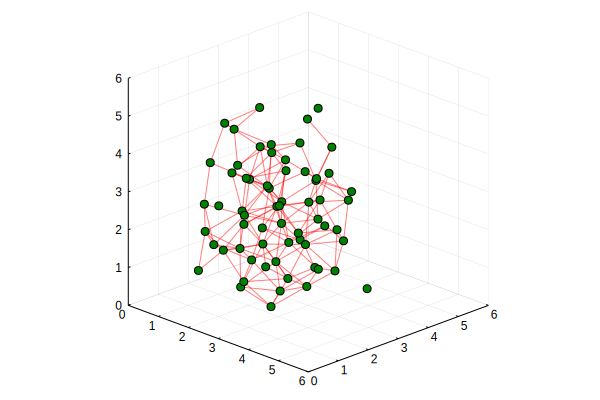

Animation("C:\\Users\\JUN\\AppData\\Local\\Temp\\jl_SV2869", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000192.png", "000193.png", "000194.png", "000195.png", "000196.png", "000197.png", "000198.png", "000199.png", "000200.png", "000201.png"])

In [7]:
skip=10
anim=grAnim(Uxlist,skip)

┌ Info: Saved animation to 
│   fn = C:\Users\JUN\Documents\Julia_notebook\github\LJポテンシャル(RK4)\tmp.gif
└ @ Plots C:\Users\JUN\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\JUN\\Documents\\Julia_notebook\\github\\LJポテンシャル(RK4)\\tmp.gif")
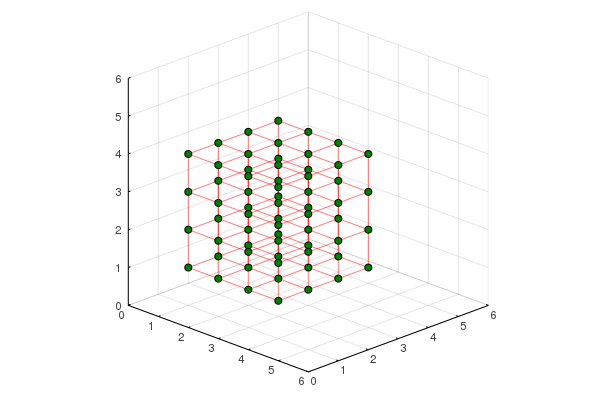

In [8]:
gif(anim,fps=30)

plotly()で最終時間3D確認

In [9]:
function plotlyView(Uxlist)
    plotly()
    i=size(Uxlist)[3]
    scene=scatter(aspect_ratio=:equal,lims=(0,6),legend=:none,camera=(45,45))
    xx=fill(NaN,size(Uxlist)[1]*30,3)
    numline=0
    for j in 1:N
        for k in (j+1):N
            rr=norm(Uxlist[j,:,i]-Uxlist[k,:,i])
            if rr ≤ 1.1
                xx[3numline+1,:]=Uxlist[j,:,i]
                xx[3numline+2,:]=Uxlist[k,:,i]
                numline+=1
            end
        end
    end
    plot!(scene,xx[1:3numline,1],xx[1:3numline,2],xx[1:3numline,3],linecolor=:red)
    scatter!(scene,Uxlist[:,1,i],Uxlist[:,2,i],Uxlist[:,3,i],markercolor=:green)
    display(scene)
end

plotlyView (generic function with 1 method)

In [13]:
plotlyView(Uxlist)

<!DOCTYPE html>
 
 
 Plots.jl

plotly()なんか遅い&アスペクトが変